**INPUTS**  
db_regression_sample.csv  
flights_scaled.csv  
**OUTPUTS**\
db_multiclass_data.csv\
Regression.sav\
y_eva.csv

# 1. Regression problem
**Goal**: predict arrival delays of flights one week in advance  

**Description**: This notebooks was used to create a ML algorythm that predicts arrival delays of flights. The input data comes from the file *flights_scaled.csv* that had the following transformations
- drop column `DELAYED_TYPE` 
- drop column ` CANCELLED` 

**Target variable**: `ARR_DELAY`  

**Steps**:
1. Pick evaluation metrics and models to try
2. Spot check different algos based on **a sample data** using cross validate
3. Select a model
4. Split training/testing data on **the whole dataset**
5. Tune hyperparameters on selected algo on **training data** using grid search
6. Train selected algo & parameters on the **training data**
7. Test performance on **testing data**
8. Save with pickle

**Notes:**
- 35% of the dataset has values (positive or negative) in `ARR_DELAY`
- [Reading on linear regression](https://machinelearningmastery.com/linear-regression-for-machine-learning/)

## 1. Pick evaluation metrics and models to try
**Evaluation metrics** 
- R Square
- MSE

**Models to try**
- Naive algorythm (used as a baseline model):  
Predict the average delay for all

- Linear algorythms:  
Linear Regression
Polynomial regression  
Lasso Regression  
Ridge Regression  
ElasticNet Regression   

- Ensemble algorythms:  
Random forest  
Stochastic Gradient Boosting  
XGBoost  

## 2. Spot check different algos based on **a sample data** using cross validate

In [1]:
import numpy as np
import pandas as pd

In [2]:
# get data from the two samples (10 000 data points)
data_sample = pd.read_csv('db_regression_sample.csv', index_col = 0)
print(data_sample.shape)
print(data_sample.columns)

data_pca_sample = pd.read_csv('db_regression_pca_sample.csv', index_col = 0)
print(data_sample.shape)
print(data_sample.columns)

(10000, 18)
Index(['branded_code_share', 'origin', 'dest', 'crs_dep_time', 'crs_arr_time',
       'crs_elapsed_time', 'air_time', 'distance', 'fl_month',
       'fl_day_of_week', 'fl_week_of_month', 'mkt_op_combo', 'fl_type',
       'm_hist_dep_delay', 'med_hist_dep_delay', 'm_hist_arr_delay',
       'med_hist_arr_delay', 'arr_delay'],
      dtype='object')
(10000, 18)
Index(['branded_code_share', 'origin', 'dest', 'crs_dep_time', 'crs_arr_time',
       'crs_elapsed_time', 'air_time', 'distance', 'fl_month',
       'fl_day_of_week', 'fl_week_of_month', 'mkt_op_combo', 'fl_type',
       'm_hist_dep_delay', 'med_hist_dep_delay', 'm_hist_arr_delay',
       'med_hist_arr_delay', 'arr_delay'],
      dtype='object')


In [3]:
# Split between target variable and dependant variables

y_sample = data_sample.arr_delay
X_sample = data_sample.drop('arr_delay', axis = 1)
print(y_sample.shape)
print(X_sample.shape)

y_pca_sample = data_pca_sample.arr_delay
X_pca_sample = data_pca_sample.drop('arr_delay', axis = 1)
print(y_pca_sample.shape)
print(X_pca_sample.shape)

(10000,)
(10000, 17)
(10000,)
(10000, 5)


In [4]:
# Function to perform cross validation on the data. 

def perform_cross_validate(models, X, y, scoring, n_folds, plot = False):
    
    # import cross validate
    from sklearn.model_selection import cross_validate
    import pandas as pd
    import numpy as np
    
    # create dataframe
    results_mean = pd.DataFrame(columns = list(models.keys()), index=list(scoring))
    results_std = pd.DataFrame(columns = list(models.keys()),  index=list(scoring))
    

    # perform cross validate and store desults in the dataframe
    for key in models:
        model_name = key
        model = models[key]  # this is the model's placeholder
        cv = cross_validate(estimator=model, X=X, y=y, cv=n_folds, scoring=scoring)
    
        # adds values for each scoring in the dataframes
        results_mean[model_name] = [cv['test_'+scoring[i]].mean() for i in range(len(scoring))]
        results_std[model_name] = [cv['test_'+scoring[i]].std() for i in range(len(scoring))]
        
        
    if plot:
        #setup
        to_plot = {0:311, 1:312, 2:313, 3:314, 4:315, 5:316}
        import matplotlib.pyplot as plt
        %matplotlib inline
        from matplotlib.pylab import rcParams
        rcParams['figure.figsize'] = 20, 15
        
        # plot
        for i, score in enumerate(scoring):
            plt.subplot(to_plot[i])
            plt.bar(list(results_mean.columns),  results_mean.iloc[i].values)
            plt.title(f'Plot for: {score}')
            
    return results_mean, results_std

In [5]:
# import models to try
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

###  Cross validate using db_regression_sample.csv, 5 folds

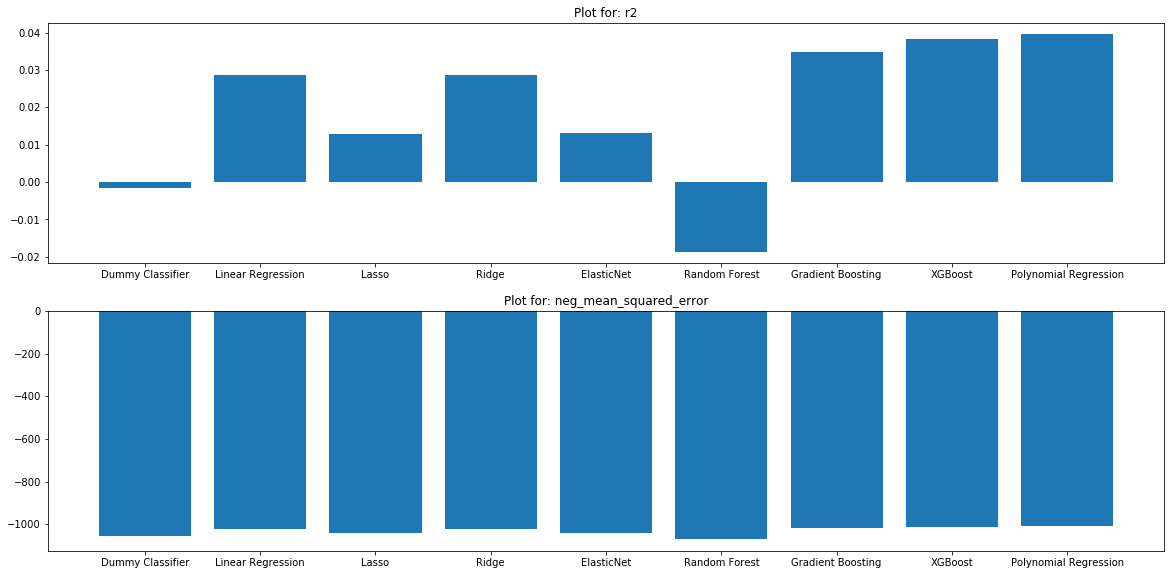

In [6]:
# params
models = {
    'Dummy Classifier': DummyRegressor(strategy = "mean"), \
    'Linear Regression': LinearRegression(), \
    'Lasso': Lasso(), \
    'Ridge': Ridge(), \
    'ElasticNet': ElasticNet(), \
    'Random Forest': RandomForestRegressor(), \
    'Gradient Boosting': GradientBoostingRegressor(), \
    'XGBoost': xgb.XGBRegressor(objective = 'reg:squarederror', n_jobs=-1), \
    'Polynomial Regression': make_pipeline(PolynomialFeatures(2),LinearRegression()) \
    }

scoring = ('r2', 'neg_mean_squared_error')

# call function
results_mean, results_std = perform_cross_validate(models=models, X=X_sample, y=y_sample, scoring=scoring, n_folds=5, plot=True)

In [7]:
results_mean

,Dummy Classifier,Linear Regression,Lasso,Ridge,ElasticNet,Random Forest,Gradient Boosting,XGBoost,Polynomial Regression
r2,-0.001699,0.028516,0.012835,0.028534,0.013005,-0.018724,0.034906,0.038387,0.039582
neg_mean_squared_error,-1053.488761,-1021.336579,-1038.129453,-1021.318443,-1037.897517,-1069.850175,-1014.211718,-1010.656548,-1008.823907


### Note: 
The sign of Mean Squared error is switched when using cross validate. It is because a maximizing function can be used

### Cross validate using db_regression_pca_sample.csv, 5 folds 

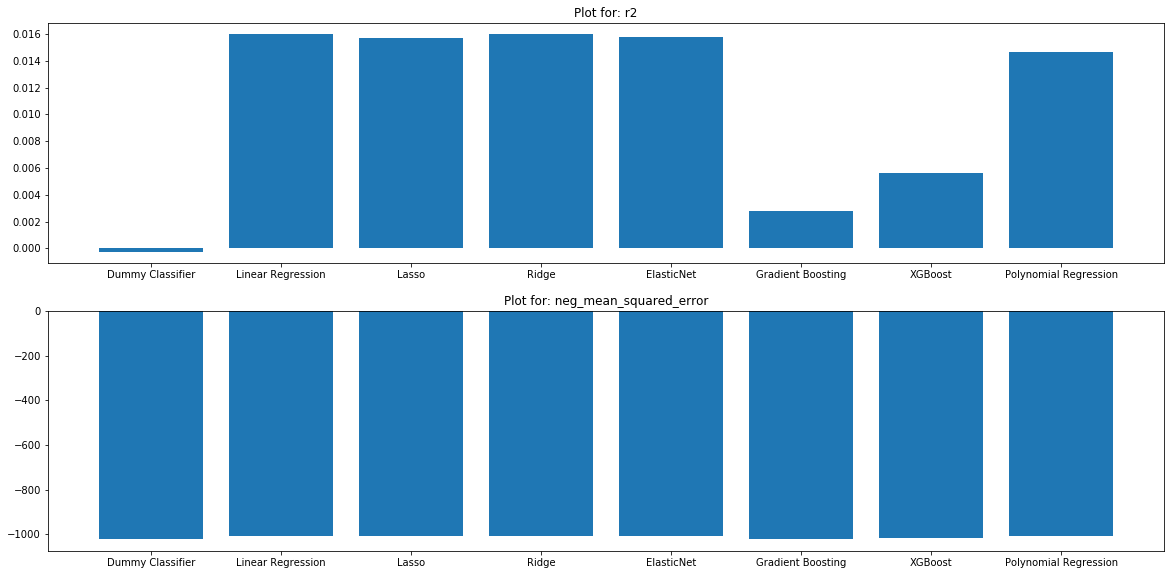

In [8]:
# params
models = {
    'Dummy Classifier': DummyRegressor(strategy = "mean"), \
    'Linear Regression': LinearRegression(), \
    'Lasso': Lasso(), \
    'Ridge': Ridge(), \
    'ElasticNet': ElasticNet(), \
    'Gradient Boosting': GradientBoostingRegressor(), \
    'XGBoost': xgb.XGBRegressor(objective = 'reg:squarederror', n_jobs=-1), \
    'Polynomial Regression': make_pipeline(PolynomialFeatures(2),LinearRegression()) \
    }

scoring = ('r2', 'neg_mean_squared_error')

# call function
results_mean_pca, results_std_pca = perform_cross_validate(models=models, X=X_pca_sample, y=y_pca_sample, scoring=scoring, n_folds=5, plot=True)

In [9]:
results_mean_pca

,Dummy Classifier,Linear Regression,Lasso,Ridge,ElasticNet,Gradient Boosting,XGBoost,Polynomial Regression
r2,-0.000282,0.016002,0.015739,0.016002,0.015753,0.002814,0.005626,0.014643
neg_mean_squared_error,-1023.513099,-1006.906370,-1007.129110,-1006.906320,-1007.127797,-1020.168978,-1017.337400,-1008.307753


Note: the MSE is negative when used in cross validation, this is done in case it's used in maximixation [source](https://www.kaggle.com/questions-and-answers/154600)

## 3. Select a model
All scores are really low. We looked at different feature engineering and outlier treatment on the input data and couldn't get higher scores. We will continue looking and tuning hyperparameters and working with bigger a bigger sample that didn't run through PCA.

Looking at the spot check on the first sample data, XGBoost or Polynomial would be good models to try with r2 at 0.038 and 0.039.
The second spot check gave us lower scores for all models (the best one being linear regression with r2 at 0.016.

We will move forward using **XGBoost**

## 4. Split training/and validation data on **the whole dataset**

In [10]:
# get data, the whole dataset that has been transformed and scaled

data = pd.read_csv('flights_scaled.csv', low_memory = False) # change this when I get the data
print(data.shape)

(15768083, 20)


In [11]:
# drop target variables used in other models
data = data.drop(['delay_type', 'cancelled'], axis=1)

In [103]:
# export the file used for the model 
data.to_csv('db_regression_data.csv')

In [12]:
# Split between target variable and dependant variables

y = data.arr_delay
X = data.drop('arr_delay', axis = 1)
print(y.shape)
print(X.shape)

(15768083,)
(15768083, 17)


In [13]:
# split training and testing data set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.20, random_state=42)

In [14]:
print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(12614466,)
(12614466, 17)
(3153617,)
(3153617, 17)


## 5. Tune hyperparameters on selected algo on **training data** using grid search

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
# try running model once to get an idea of the length grid search will take 
# this takes 15min on 7 million data

from sklearn.metrics import r2_score # evaluation metric
from sklearn.metrics import mean_squared_error # evaluation metric

model = xgb.XGBRegressor(objective = 'reg:squarederror', n_jobs=-1) # placeholder
model.fit(X_train, y_train) # fit
y_pred = model.predict(X_test) # predict
r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
print(f'{r2} \n{MSE}')

[01:46:26] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
0.060447857181874176 
1021.5861863412229


In [17]:
# perform grid search on sample data
# this takes 2 minutes on 10K data and 16 parameters

# params for grid search
params = [
    {"learning_rate"    : [0.10, 0.20, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6],
 "min_child_weight" : [ 1, 3, 5],
 "gamma"            : [ 0.0, 0.1, 0.3, 0.5],
 "colsample_bytree" : [ 0.3, 0.5] }
]

model = xgb.XGBRegressor(objective = 'reg:squarederror', n_jobs=-1)
xgbg = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1)

xgbg.fit(X_sample, y_sample)

print(xgbg.best_params_)
best_model = xgbg.best_estimator_

{'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5}


We will use those parameters for training the model on the whole training dataset

## 6. Train selected algo & parameters on the **training data**

In [18]:
# try model with best parameters from grid search (grid search was based on sample data)

model = best_model
model.fit(X_train, y_train) # fit

[02:02:27] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBRegressor(colsample_bytree=0.5, gamma=0.0, max_depth=4, min_child_weight=5,
             n_jobs=-1, objective='reg:squarederror')

## 7. Test performance on **testing data**

In [19]:
# Model evaluation metrics

y_pred = model.predict(X_test) # predict
r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
print(f'{r2} \n{MSE}')

0.06623504253160284 
1015.2937110845053


In [20]:
y_pred.mean()

2.7016962

## 8. Save with pickle

In [21]:
import pickle

In [22]:
filename = 'Regression.sav'
pickle.dump(best_model, open(filename, 'wb'))

In [23]:
loaded_model = pickle.load(open('Regression.sav', 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.06623504253160284


## 9. Predict on evaluation data

In [24]:
X_eval = pd.read_csv('X_eval_reg.csv', low_memory = False)

In [25]:
X_eval.head()

,branded_code_share,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,air_time,distance,fl_month,fl_day_of_week,fl_week_of_month,mkt_op_combo,fl_type,m_hist_dep_delay,med_hist_dep_delay,m_hist_arr_delay,med_hist_arr_delay
0,-0.778808,0.721583,1.384100,1.019724,0.865216,-0.598453,0.000022,-0.691421,-1.641708,-0.469654,-1.606868,1.343235,-0.520179,1.300751,0.927402,1.392198,1.428389
1,-0.778808,0.721583,1.384100,-0.415251,-0.304796,-0.668266,0.000022,-0.691421,-1.641708,-0.469654,-1.606868,1.343235,-0.520179,-0.345562,0.049163,-0.473004,-0.612590
2,-0.778808,0.721583,1.443483,1.429717,1.255220,-0.947516,0.000022,-0.742637,-1.641708,-0.469654,-1.606868,1.343235,-0.520179,1.245822,0.927402,1.187196,1.428389
3,-0.778808,0.721583,1.443483,-0.005258,-0.109794,-0.877704,0.000022,-0.742637,-1.641708,-0.469654,-1.606868,1.343235,-0.520179,0.098755,0.049163,0.097369,-0.102345
4,-0.778808,0.721583,1.443483,-0.825243,-0.889802,-0.807891,0.000022,-0.742637,-1.641708,-0.469654,-1.606868,1.343235,-0.520179,-0.789925,-0.829076,-0.847365,-0.612590


In [26]:
y_eva = model.predict(X_eval)

In [27]:
y_eva.mean()

16.506462

In [28]:
pd.DataFrame(y_eva).to_csv('y_eva.csv')